In [1]:
import numpy as np
import pandas as pd
import os
from os import path
from glob import glob
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from utils import *
from processing import *
import subspaceMSI
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from signal_model import *
from scipy.stats import pearsonr,spearmanr
from scipy.signal import medfilt
import h5py
from numpy.fft import rfft
from scipy.signal import find_peaks_cwt, find_peaks
from scipy.stats import median_abs_deviation as mad
from pyimzml.ImzMLWriter import ImzMLWriter


ImportError: Something is wrong with the numpy installation. While importing we detected an older version of numpy in ['/Users/richard/anaconda/lib/python3.6/site-packages/numpy']. One method of fixing this is to repeatedly uninstall numpy until none is found, then reinstall this version.

In [2]:
recon_ = subspaceMSI.Subspace(out_dir='../processed_data')
recon_.experimentInfo('../file_dir_singlecell_train.json', if_simu = True, sampling_pattern = None)
m_HR = recon_.parameters['m_HR']
t = recon_.parameters['t_HR']
m_LR = recon_.parameters['m_LR']
t_LR = recon_.parameters['t_LR']

NameError: name 'subspaceMSI' is not defined

In [6]:
# file_path = 'Z:/Ellis_Joanna/Raw Files for 30k Cells/'
# cell_file_dir = ['20171016/Scene 1','20171016/Scene 2','20171016/Scene 3','20171016/Scene 4',
#                 '20171026/Slide 3/Scene 1','20171026/Slide 3/Scene 2','20171026/Slide 3/Scene 3','20171026/Slide 3/Scene 4',
#                 '20171026/Slide 4/Scene 1','20171026/Slide 4/Scene 2','20171026/Slide 4/Scene 3','20171026/Slide 4/Scene 4',
#                 '20171103/Slide 1/Scene 1','20171103/Slide 1/Scene 2','20171103/Slide 1/Scene 3','20171103/Slide 1/Scene 4',
#                 '20171103/Slide 2/Scene 1','20171103/Slide 2/Scene 2','20171103/Slide 2/Scene 3','20171103/Slide 2/Scene 4',
#                 '20171103/Slide 3/Scene 1','20171103/Slide 3/Scene 2','20171103/Slide 3/Scene 3','20171103/Slide 3/Scene 4',
#                 '20171103/Slide 4/Scene 1','20171103/Slide 4/Scene 2','20171103/Slide 4/Scene 3','20171103/Slide 4/Scene 4',
#                 '20171117/Slide 1/Scene 1','20171117/Slide 1/Scene 2','20171117/Slide 1/Scene 3','20171117/Slide 1/Scene 4',
#                 '20171117/Slide 2/Scene 1','20171117/Slide 2/Scene 2','20171117/Slide 2/Scene 3','20171117/Slide 2/Scene 4',
#                 '20171121/Slide 1/Scene 1','20171121/Slide 1/Scene 2','20171121/Slide 1/Scene 3','20171121/Slide 1/Scene 4',
#                 '20171121/Slide 2/Scene 1','20171121/Slide 2/Scene 2','20171121/Slide 2/Scene 3','20171121/Slide 2/Scene 4',
#                 '20171121/Slide 3/Scene 1','20171121/Slide 3/Scene 2','20171121/Slide 3/Scene 3','20171121/Slide 3/Scene 4'
#                 ]
file_path = 'V/20220209_BrainDissociate3D/'
cell_file_dir = ['Slide1_Composite','Slide2_Composite']
#cell_file_dir = ['Slide3_IndividualRegions/','Slide4_IndividualRegions/']
# cell_file_dir = ['Slide5_IndividualRegions/','Slide6_IndividualRegions/','Slide7_IndividualRegions/','Slide8_IndividualRegions/',
#                 'Slide9_IndividualRegions/','Slide10_IndividualRegions/']
# regions = ['Corpus','Cortex','Hip','Striatum','Thalamus']

In [11]:
from glob import glob

In [12]:
cell_ser_file_dir = []
for cell_file_dir_ in cell_file_dir:
    #for region in regions:
        cell_ser_file_dir += glob(file_path+cell_file_dir_+'/*.d')

In [13]:
len(cell_ser_file_dir)

0

In [67]:
cell_ser_file_dir[-1]

'E:/20220209_BrainDissociate3D/Slide4_IndividualRegions/Thalamus\\x_50351y_12020.d'

In [122]:
#download the data and store in the h5 file

hf = h5py.File('E:/20220209_BrainDissociate3D/raw_sc_regional.h5', 'w')

for i in tqdm(range(0,len(cell_ser_file_dir))):
    cell = cell_ser_file_dir[i]
    if os.path.exists(cell_ser_file_dir[i]+'/ser'):
        fid_loaded = loadBrukerFIDs(cell_ser_file_dir[i]+'/ser', 
                                recon_.parameters['fid_length_LR'], 
                                'all',
                                1)
        #mz,sp = fid2spec(fid_loaded,m_HR,(150,3000))
        group = hf.create_group(cell_ser_file_dir[i])
        cell_names = cell.split('/')
        group.create_dataset('transient',data=fid_loaded)
        #group.create_dataset('batch',data=cell_names[3])
        group.create_dataset('cell name',data=cell.split('/')[-1].split('\\'))
    #group.create_dataset('spectra',data=sp)
hf.close()

100%|████████████████████████████████████████████████████████████████████████████| 13740/13740 [06:25<00:00, 35.68it/s]


In [6]:
# def get_dataset_keys(f):
#     keys = []
#     f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
#     return keys

# with h5py.File('E:/deepMSI_singlecell/raw_transient_singlecell.h5','r') as h5:
#     dataset_names = get_dataset_keys(h5)
# dataset_combined = '\t'.join(dataset_names)

# cell_file_names = []
# for cell in cell_ser_file_dir:
#     if cell in dataset_combined:
#         cell_file_names.append(cell)

In [32]:
#pd.DataFrame(cell_file_names).to_csv('../cell_file_names.csv')
cell_file_names = list(pd.read_csv('../cell_file_names.csv')['0'].values)

In [33]:
np.random.seed(19)
names_train = np.random.choice(cell_file_names,5000)

In [20]:
from train import *
data_file_path = 'E:/20220209_BrainDissociate3D/raw_sc_composite_train.h5'
fid_length = recon_.parameters['fid_length_HR']

In [21]:
model, encoder,decoder = ae_architecture(int(recon_.parameters['fid_length_HR']), 32)

trainDecoder_singlecell(64, 20, cell_ser_file_dir , data_file_path, fid_length, fid_length, model)

  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 0


 17%|█████████████▊                                                                    | 15/89 [02:33<12:56, 10.49s/it]

Training loss (for one batch) at step 15: 5757.5000


 34%|███████████████████████████▋                                                      | 30/89 [05:17<11:22, 11.57s/it]

Training loss (for one batch) at step 30: 3844.4626


 51%|█████████████████████████████████████████▍                                        | 45/89 [08:07<08:35, 11.72s/it]

Training loss (for one batch) at step 45: 2766.8752


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [11:12<06:25, 13.30s/it]

Training loss (for one batch) at step 60: 3518.1780


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [14:33<03:06, 13.31s/it]

Training loss (for one batch) at step 75: 2665.5874


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 1


 17%|█████████████▊                                                                    | 15/89 [01:56<09:51,  7.99s/it]

Training loss (for one batch) at step 15: 2111.9746


 34%|███████████████████████████▋                                                      | 30/89 [04:02<08:26,  8.59s/it]

Training loss (for one batch) at step 30: 2429.6475


 51%|█████████████████████████████████████████▍                                        | 45/89 [06:23<07:18,  9.97s/it]

Training loss (for one batch) at step 45: 2302.0767


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [09:15<05:53, 12.18s/it]

Training loss (for one batch) at step 60: 2193.7173


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [12:40<03:12, 13.74s/it]

Training loss (for one batch) at step 75: 2199.9697


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 2


 17%|█████████████▊                                                                    | 15/89 [02:00<10:19,  8.37s/it]

Training loss (for one batch) at step 15: 1937.6294


 34%|███████████████████████████▋                                                      | 30/89 [04:12<08:49,  8.98s/it]

Training loss (for one batch) at step 30: 1989.1552


 51%|█████████████████████████████████████████▍                                        | 45/89 [06:37<07:26, 10.16s/it]

Training loss (for one batch) at step 45: 1770.6666


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [09:36<06:15, 12.95s/it]

Training loss (for one batch) at step 60: 2117.2686


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [13:05<03:13, 13.83s/it]

Training loss (for one batch) at step 75: 1809.5569


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 3


 17%|█████████████▊                                                                    | 15/89 [01:57<10:08,  8.22s/it]

Training loss (for one batch) at step 15: 1957.3065


 34%|███████████████████████████▋                                                      | 30/89 [04:07<08:47,  8.94s/it]

Training loss (for one batch) at step 30: 1652.1223


 51%|█████████████████████████████████████████▍                                        | 45/89 [06:33<07:20, 10.02s/it]

Training loss (for one batch) at step 45: 1873.9463


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [09:28<06:14, 12.92s/it]

Training loss (for one batch) at step 60: 1878.1687


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [12:54<03:12, 13.77s/it]

Training loss (for one batch) at step 75: 1660.1100


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 4


 17%|█████████████▊                                                                    | 15/89 [01:59<10:09,  8.24s/it]

Training loss (for one batch) at step 15: 1725.9045


 34%|███████████████████████████▋                                                      | 30/89 [04:11<08:40,  8.82s/it]

Training loss (for one batch) at step 30: 1843.5247


 51%|█████████████████████████████████████████▍                                        | 45/89 [06:43<07:50, 10.69s/it]

Training loss (for one batch) at step 45: 2068.0237


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [09:32<05:47, 11.98s/it]

Training loss (for one batch) at step 60: 1759.0176


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [12:55<03:10, 13.62s/it]

Training loss (for one batch) at step 75: 1747.9053


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 5


 17%|█████████████▊                                                                    | 15/89 [02:00<10:04,  8.17s/it]

Training loss (for one batch) at step 15: 1645.5726


 34%|███████████████████████████▋                                                      | 30/89 [04:15<09:06,  9.26s/it]

Training loss (for one batch) at step 30: 1626.6732


 51%|█████████████████████████████████████████▍                                        | 45/89 [06:33<06:59,  9.54s/it]

Training loss (for one batch) at step 45: 1682.2710


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [09:21<05:59, 12.41s/it]

Training loss (for one batch) at step 60: 1885.7784


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [12:44<03:10, 13.63s/it]

Training loss (for one batch) at step 75: 1727.0518


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 6


 17%|█████████████▊                                                                    | 15/89 [01:59<10:08,  8.23s/it]

Training loss (for one batch) at step 15: 1700.5833


 34%|███████████████████████████▋                                                      | 30/89 [04:04<08:27,  8.60s/it]

Training loss (for one batch) at step 30: 1638.7158


 51%|█████████████████████████████████████████▍                                        | 45/89 [06:29<07:13,  9.86s/it]

Training loss (for one batch) at step 45: 1699.2037


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [09:20<05:57, 12.32s/it]

Training loss (for one batch) at step 60: 1760.9728


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [12:38<03:06, 13.32s/it]

Training loss (for one batch) at step 75: 1710.8188


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 7


 17%|█████████████▊                                                                    | 15/89 [01:58<10:03,  8.16s/it]

Training loss (for one batch) at step 15: 1540.3209


 34%|███████████████████████████▋                                                      | 30/89 [04:05<08:42,  8.86s/it]

Training loss (for one batch) at step 30: 1555.8535


 51%|█████████████████████████████████████████▍                                        | 45/89 [06:27<07:30, 10.23s/it]

Training loss (for one batch) at step 45: 1533.0118


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [09:19<06:02, 12.50s/it]

Training loss (for one batch) at step 60: 1798.6001


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [12:34<03:00, 12.91s/it]

Training loss (for one batch) at step 75: 1646.3074


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 8


 17%|█████████████▊                                                                    | 15/89 [02:02<10:30,  8.52s/it]

Training loss (for one batch) at step 15: 1626.3550


 34%|███████████████████████████▋                                                      | 30/89 [04:17<09:01,  9.17s/it]

Training loss (for one batch) at step 30: 1604.2333


 51%|█████████████████████████████████████████▍                                        | 45/89 [06:39<07:06,  9.70s/it]

Training loss (for one batch) at step 45: 1625.2544


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [09:29<05:50, 12.08s/it]

Training loss (for one batch) at step 60: 1517.0896


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [12:40<03:01, 12.93s/it]

Training loss (for one batch) at step 75: 1779.1011


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 9


 17%|█████████████▊                                                                    | 15/89 [01:58<10:06,  8.20s/it]

Training loss (for one batch) at step 15: 1480.2333


 34%|███████████████████████████▋                                                      | 30/89 [04:05<08:51,  9.00s/it]

Training loss (for one batch) at step 30: 1506.7975


 51%|█████████████████████████████████████████▍                                        | 45/89 [06:26<07:02,  9.61s/it]

Training loss (for one batch) at step 45: 1582.2224


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [09:12<05:42, 11.82s/it]

Training loss (for one batch) at step 60: 1706.9541


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [12:28<03:03, 13.11s/it]

Training loss (for one batch) at step 75: 1814.7151


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 10


 17%|█████████████▊                                                                    | 15/89 [01:57<09:21,  7.59s/it]

Training loss (for one batch) at step 15: 1618.5193


 34%|███████████████████████████▋                                                      | 30/89 [04:00<08:17,  8.44s/it]

Training loss (for one batch) at step 30: 1557.9871


 51%|█████████████████████████████████████████▍                                        | 45/89 [06:17<06:43,  9.18s/it]

Training loss (for one batch) at step 45: 1572.7745


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [09:01<05:39, 11.71s/it]

Training loss (for one batch) at step 60: 1522.7263


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [12:14<03:02, 13.05s/it]

Training loss (for one batch) at step 75: 1526.7314


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 11


 17%|█████████████▊                                                                    | 15/89 [01:52<09:37,  7.81s/it]

Training loss (for one batch) at step 15: 1432.1987


 34%|███████████████████████████▋                                                      | 30/89 [03:55<08:36,  8.75s/it]

Training loss (for one batch) at step 30: 1518.2866


 51%|█████████████████████████████████████████▍                                        | 45/89 [06:14<07:05,  9.67s/it]

Training loss (for one batch) at step 45: 1467.9889


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [08:56<05:32, 11.47s/it]

Training loss (for one batch) at step 60: 1531.2444


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [12:01<02:54, 12.43s/it]

Training loss (for one batch) at step 75: 1545.8467


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 12


 17%|█████████████▊                                                                    | 15/89 [01:56<09:42,  7.87s/it]

Training loss (for one batch) at step 15: 1464.6007


 34%|███████████████████████████▋                                                      | 30/89 [04:01<08:26,  8.59s/it]

Training loss (for one batch) at step 30: 1528.1316


 51%|█████████████████████████████████████████▍                                        | 45/89 [06:21<06:49,  9.32s/it]

Training loss (for one batch) at step 45: 1557.9836


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [09:02<05:34, 11.53s/it]

Training loss (for one batch) at step 60: 1557.9158


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [12:07<02:51, 12.28s/it]

Training loss (for one batch) at step 75: 1521.8359


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 13


 17%|█████████████▊                                                                    | 15/89 [01:53<09:07,  7.40s/it]

Training loss (for one batch) at step 15: 1471.4292


 34%|███████████████████████████▋                                                      | 30/89 [03:52<07:51,  7.98s/it]

Training loss (for one batch) at step 30: 1650.4918


 51%|█████████████████████████████████████████▍                                        | 45/89 [06:04<06:32,  8.92s/it]

Training loss (for one batch) at step 45: 1497.9652


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [08:37<05:17, 10.95s/it]

Training loss (for one batch) at step 60: 1491.0674


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [11:33<02:45, 11.82s/it]

Training loss (for one batch) at step 75: 1566.2031


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 14


 17%|█████████████▊                                                                    | 15/89 [01:48<09:05,  7.37s/it]

Training loss (for one batch) at step 15: 1546.5001


 34%|███████████████████████████▋                                                      | 30/89 [03:47<07:51,  7.99s/it]

Training loss (for one batch) at step 30: 1560.0452


 51%|█████████████████████████████████████████▍                                        | 45/89 [05:57<06:28,  8.84s/it]

Training loss (for one batch) at step 45: 1522.0032


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [08:30<05:21, 11.08s/it]

Training loss (for one batch) at step 60: 1501.4202


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [11:27<02:45, 11.81s/it]

Training loss (for one batch) at step 75: 1522.2915


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 15


 17%|█████████████▊                                                                    | 15/89 [01:49<08:50,  7.17s/it]

Training loss (for one batch) at step 15: 1595.5549


 34%|███████████████████████████▋                                                      | 30/89 [03:44<07:27,  7.59s/it]

Training loss (for one batch) at step 30: 1537.9685


 51%|█████████████████████████████████████████▍                                        | 45/89 [05:55<06:46,  9.25s/it]

Training loss (for one batch) at step 45: 1584.0327


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [08:28<05:23, 11.17s/it]

Training loss (for one batch) at step 60: 1477.7517


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [11:25<02:44, 11.73s/it]

Training loss (for one batch) at step 75: 1641.1389


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 16


 17%|█████████████▊                                                                    | 15/89 [01:51<09:16,  7.52s/it]

Training loss (for one batch) at step 15: 1582.6011


 34%|███████████████████████████▋                                                      | 30/89 [03:51<08:16,  8.42s/it]

Training loss (for one batch) at step 30: 1562.6405


 51%|█████████████████████████████████████████▍                                        | 45/89 [06:03<06:37,  9.04s/it]

Training loss (for one batch) at step 45: 1552.9014


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [08:33<05:06, 10.58s/it]

Training loss (for one batch) at step 60: 1512.4480


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [11:29<02:43, 11.65s/it]

Training loss (for one batch) at step 75: 1497.2711


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 17


 17%|█████████████▊                                                                    | 15/89 [01:45<08:44,  7.08s/it]

Training loss (for one batch) at step 15: 1538.5416


 34%|███████████████████████████▋                                                      | 30/89 [03:39<07:35,  7.71s/it]

Training loss (for one batch) at step 30: 1479.8137


 51%|█████████████████████████████████████████▍                                        | 45/89 [05:44<06:19,  8.64s/it]

Training loss (for one batch) at step 45: 1562.3131


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [08:12<05:03, 10.48s/it]

Training loss (for one batch) at step 60: 1572.7104


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [11:07<02:44, 11.76s/it]

Training loss (for one batch) at step 75: 1460.4612


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 18


 17%|█████████████▊                                                                    | 15/89 [01:48<09:16,  7.53s/it]

Training loss (for one batch) at step 15: 1588.7876


 34%|███████████████████████████▋                                                      | 30/89 [03:39<07:45,  7.90s/it]

Training loss (for one batch) at step 30: 1462.7974


 51%|█████████████████████████████████████████▍                                        | 45/89 [05:47<06:28,  8.83s/it]

Training loss (for one batch) at step 45: 1505.7764


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [08:11<04:58, 10.31s/it]

Training loss (for one batch) at step 60: 1492.1506


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [11:06<02:44, 11.78s/it]

Training loss (for one batch) at step 75: 1495.3494


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]


Start of epoch 19


 17%|█████████████▊                                                                    | 15/89 [01:41<08:35,  6.97s/it]

Training loss (for one batch) at step 15: 1431.2288


 34%|███████████████████████████▋                                                      | 30/89 [03:34<07:10,  7.30s/it]

Training loss (for one batch) at step 30: 1515.5037


 51%|█████████████████████████████████████████▍                                        | 45/89 [05:37<06:15,  8.54s/it]

Training loss (for one batch) at step 45: 1475.5037


 67%|███████████████████████████████████████████████████████▎                          | 60/89 [08:00<04:53, 10.13s/it]

Training loss (for one batch) at step 60: 1484.5376


 84%|█████████████████████████████████████████████████████████████████████             | 75/89 [10:54<02:45, 11.80s/it]

Training loss (for one batch) at step 75: 1476.4880


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [13:38<00:00,  9.20s/it]


[6602.034,
 2245.0288,
 1911.034,
 1805.2517,
 1821.1694,
 1757.7003,
 1677.3453,
 1620.1129,
 1632.047,
 1595.2627,
 1570.4608,
 1554.6255,
 1556.6735,
 1543.7058,
 1567.5068,
 1571.186,
 1544.0323,
 1500.3523,
 1491.8738,
 1502.6522]

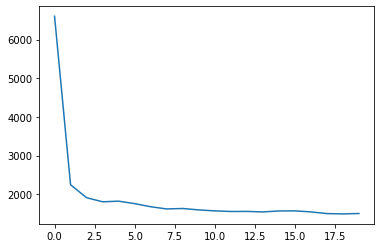

In [22]:
plt.plot([6602.034,
 2245.0288,
 1911.034,
 1805.2517,
 1821.1694,
 1757.7003,
 1677.3453,
 1620.1129,
 1632.047,
 1595.2627,
 1570.4608,
 1554.6255,
 1556.6735,
 1543.7058,
 1567.5068,
 1571.186,
 1544.0323,
 1500.3523,
 1491.8738,
 1502.6522])

In [57]:
encoder.save('../saved_model/raw_sc_composite_encoder')
decoder.save('../saved_model/raw_sc_composite_decoder')

INFO:tensorflow:Assets written to: ../saved_model/raw_sc_composite_encoder\assets
INFO:tensorflow:Assets written to: ../saved_model/raw_sc_composite_decoder\assets


In [26]:
with h5py.File('E:/20220209_BrainDissociate3D/raw_sc_composite_train.h5','r') as h5:
    fid_loaded = np.array(h5[cell_ser_file_dir[1321]].get('transient'))[:,:fid_length]
fid_pred=model.predict(fid_loaded)

In [29]:
signal_encodings = []
for i in tqdm(range(len(cell_ser_file_dir))):
    with h5py.File('E:/20220209_BrainDissociate3D/raw_sc_composite_train.h5','r') as h5:
        fid_loaded = np.array(h5[cell_ser_file_dir[i]].get('transient'))[:,:fid_length]
        signal_encodings.append(encoder(fid_loaded))

100%|██████████████████████████████████████████████████████████████████████████████| 5680/5680 [20:17<00:00,  4.67it/s]


In [32]:
# signal_encodings_train = np.array(signal_encodings)[:,0]
# np.save('../raw_sc_composite_train_encoded.npy',signal_encodings_train)
signal_encodings_train = np.load('../raw_sc_composite_train_encoded.npy')

In [33]:
model_lp = lp_architecture(65536, 32)
trainRegressor_singlecell(64,50,signal_encodings_train, cell_ser_file_dir, data_file_path, fid_length, 65536, model_lp)

  0%|▏                                                                              | 14/5680 [00:00<00:43, 131.16it/s]

loading training data for the regressor...


  1%|▉                                                                                  | 1/89 [00:00<00:13,  6.31it/s]


Start of epoch 0


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  9.07it/s]

Training loss (for one batch) at step 50: 202906000.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.20it/s]


Start of epoch 1


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  9.01it/s]

Training loss (for one batch) at step 50: 49993164.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.03it/s]


Start of epoch 2


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.97it/s]

Training loss (for one batch) at step 50: 29267664.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.03it/s]


Start of epoch 3


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.88it/s]

Training loss (for one batch) at step 50: 21443360.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  8.87it/s]


Start of epoch 4


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.81it/s]

Training loss (for one batch) at step 50: 10269924.0000


  1%|▉                                                                                  | 1/89 [00:00<00:10,  8.80it/s]


Start of epoch 5


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.84it/s]

Training loss (for one batch) at step 50: 14108930.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  8.95it/s]


Start of epoch 6


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.82it/s]

Training loss (for one batch) at step 50: 12956263.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  8.95it/s]


Start of epoch 7


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.86it/s]

Training loss (for one batch) at step 50: 9354719.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  8.95it/s]


Start of epoch 8


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.81it/s]

Training loss (for one batch) at step 50: 9966182.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  8.87it/s]


Start of epoch 9


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.82it/s]

Training loss (for one batch) at step 50: 7816895.0000


  1%|▉                                                                                  | 1/89 [00:00<00:10,  8.72it/s]


Start of epoch 10


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.84it/s]

Training loss (for one batch) at step 50: 8041401.5000


  1%|▉                                                                                  | 1/89 [00:00<00:10,  8.80it/s]


Start of epoch 11


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.69it/s]

Training loss (for one batch) at step 50: 5707102.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  8.95it/s]


Start of epoch 12


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.84it/s]

Training loss (for one batch) at step 50: 8313270.0000


  1%|▉                                                                                  | 1/89 [00:00<00:10,  8.80it/s]


Start of epoch 13


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.68it/s]

Training loss (for one batch) at step 50: 6326026.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.12it/s]


Start of epoch 14


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.71it/s]

Training loss (for one batch) at step 50: 5089646.5000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  8.95it/s]


Start of epoch 15


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.65it/s]

Training loss (for one batch) at step 50: 5730541.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.03it/s]


Start of epoch 16


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.77it/s]

Training loss (for one batch) at step 50: 4458087.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.12it/s]


Start of epoch 17


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.95it/s]

Training loss (for one batch) at step 50: 3844880.2500


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.28it/s]


Start of epoch 18


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.91it/s]

Training loss (for one batch) at step 50: 4264929.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.20it/s]


Start of epoch 19


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.92it/s]

Training loss (for one batch) at step 50: 4241362.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.20it/s]


Start of epoch 20


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.92it/s]

Training loss (for one batch) at step 50: 4985222.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.12it/s]


Start of epoch 21


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.73it/s]

Training loss (for one batch) at step 50: 4854250.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.12it/s]


Start of epoch 22


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.82it/s]

Training loss (for one batch) at step 50: 4008565.5000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.20it/s]


Start of epoch 23


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.92it/s]

Training loss (for one batch) at step 50: 4055339.7500


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.20it/s]


Start of epoch 24


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.86it/s]

Training loss (for one batch) at step 50: 4105567.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.20it/s]


Start of epoch 25


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.87it/s]

Training loss (for one batch) at step 50: 3382236.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.20it/s]


Start of epoch 26


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.85it/s]

Training loss (for one batch) at step 50: 2918584.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  8.95it/s]


Start of epoch 27


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.76it/s]

Training loss (for one batch) at step 50: 3367712.2500


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.12it/s]


Start of epoch 28


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.94it/s]

Training loss (for one batch) at step 50: 3661083.5000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.03it/s]


Start of epoch 29


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.82it/s]

Training loss (for one batch) at step 50: 3327664.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.12it/s]


Start of epoch 30


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.94it/s]

Training loss (for one batch) at step 50: 3648309.7500


  1%|▉                                                                                  | 1/89 [00:00<00:09,  8.95it/s]


Start of epoch 31


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.88it/s]

Training loss (for one batch) at step 50: 2682880.0000


  1%|▉                                                                                  | 1/89 [00:00<00:11,  7.71it/s]


Start of epoch 32


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.86it/s]

Training loss (for one batch) at step 50: 3155557.5000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  8.95it/s]


Start of epoch 33


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.84it/s]

Training loss (for one batch) at step 50: 2837311.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  8.87it/s]


Start of epoch 34


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.87it/s]

Training loss (for one batch) at step 50: 4924371.5000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.12it/s]


Start of epoch 35


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.84it/s]

Training loss (for one batch) at step 50: 3233561.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.12it/s]


Start of epoch 36


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.79it/s]

Training loss (for one batch) at step 50: 2213783.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.12it/s]


Start of epoch 37


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.81it/s]

Training loss (for one batch) at step 50: 2520243.2500


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.12it/s]


Start of epoch 38


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.79it/s]

Training loss (for one batch) at step 50: 2852263.0000


  1%|▉                                                                                  | 1/89 [00:00<00:10,  8.72it/s]


Start of epoch 39


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.90it/s]

Training loss (for one batch) at step 50: 2879701.5000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.37it/s]


Start of epoch 40


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.98it/s]

Training loss (for one batch) at step 50: 2086168.5000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.12it/s]


Start of epoch 41


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.83it/s]

Training loss (for one batch) at step 50: 2131621.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.28it/s]


Start of epoch 42


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.94it/s]

Training loss (for one batch) at step 50: 1760976.2500


  1%|▉                                                                                  | 1/89 [00:00<00:10,  8.43it/s]


Start of epoch 43


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.88it/s]

Training loss (for one batch) at step 50: 1741167.3750


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.12it/s]


Start of epoch 44


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.90it/s]

Training loss (for one batch) at step 50: 2263423.5000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  9.12it/s]


Start of epoch 45


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.63it/s]

Training loss (for one batch) at step 50: 1526668.5000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  8.87it/s]


Start of epoch 46


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.55it/s]

Training loss (for one batch) at step 50: 2319130.5000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  8.87it/s]


Start of epoch 47


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.65it/s]

Training loss (for one batch) at step 50: 2725272.0000


  1%|▉                                                                                  | 1/89 [00:00<00:10,  8.80it/s]


Start of epoch 48


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.70it/s]

Training loss (for one batch) at step 50: 5975663.0000


  1%|▉                                                                                  | 1/89 [00:00<00:09,  8.95it/s]


Start of epoch 49


 57%|██████████████████████████████████████████████▉                                   | 51/89 [00:05<00:04,  8.65it/s]

Training loss (for one batch) at step 50: 1578949.2500


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [00:10<00:00,  8.64it/s]


[295663000.0,
 62908430.0,
 31800328.0,
 20297178.0,
 14806744.0,
 12674492.0,
 10809807.0,
 10907595.0,
 8910739.0,
 7962146.5,
 7491702.0,
 6878669.5,
 6529355.0,
 6256506.0,
 5602831.0,
 5497386.5,
 4947248.5,
 4942994.0,
 5001368.0,
 5358649.5,
 4384200.0,
 4658630.0,
 4089906.2,
 5269357.0,
 4715678.5,
 3704700.8,
 3336820.8,
 3645700.0,
 3672998.5,
 4248518.0,
 3555450.0,
 2910970.5,
 3552356.2,
 3466251.8,
 3047016.8,
 3128656.2,
 2829386.2,
 2542651.2,
 4995105.0,
 3667181.8,
 2247216.2,
 2573848.8,
 2523949.8,
 2124621.0,
 2220430.8,
 2216496.2,
 2705816.2,
 3008683.2,
 2995997.5,
 2028512.0]

In [58]:
model_lp.save('../saved_model/raw_sc_composite_regressor')

INFO:tensorflow:Assets written to: ../saved_model/raw_sc_composite_regressor\assets


In [59]:
encoder = keras.models.load_model('../saved_model/raw_sc_composite_encoder')
decoder = keras.models.load_model('../saved_model/raw_sc_composite_decoder')
model_lp = keras.models.load_model('../saved_model/raw_sc_composite_regressor')

In [35]:
with h5py.File('E:/20220209_BrainDissociate3D/raw_sc_composite_train.h5','r') as h5:
    fid_loaded = np.array(h5[cell_ser_file_dir[1233]].get('transient'))[:,:fid_length]

In [36]:
encoded_pred = model_lp.predict(fid_loaded[:,:65536])
fid_decoded = decoder(encoded_pred)

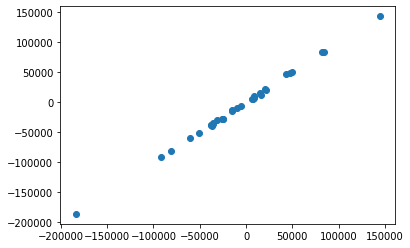

In [37]:
plt.scatter(signal_encodings_train[1233],encoded_pred)

In [45]:
signal_encodings_pred = []
for i in tqdm(range(len(cell_file_names))):
    with h5py.File('E:/deepMSI_singlecell/raw_transient_singlecell.h5','r') as h5:
        fid_loaded = np.array(h5[cell_file_names[i]].get('transient'))[:,:65536]
        if fid_loaded.shape[1] != 0:
            signal_encodings_pred.append(np.array(model_lp(fid_loaded)))
signal_encodings_pred = np.array(signal_encodings_pred)

100%|██████████████████████████████████████████████████████████████████████████| 24086/24086 [2:52:15<00:00,  2.33it/s]


In [50]:
#np.save('../singlecell_encoded_pred_all.npy',signal_encodings_pred[:,0])
signal_encodings_pred = np.load('../singlecell_encoded_pred_all.npy')

In [55]:
with h5py.File('E:/20220209_BrainDissociate3D/raw_sc_composite_train.h5','r') as h5:
    fid_loaded = np.array(h5[cell_ser_file_dir[411]].get('transient'))[:,:fid_length]
fid_decoded = decoder(signal_encodings_train[411].reshape(1,-1))

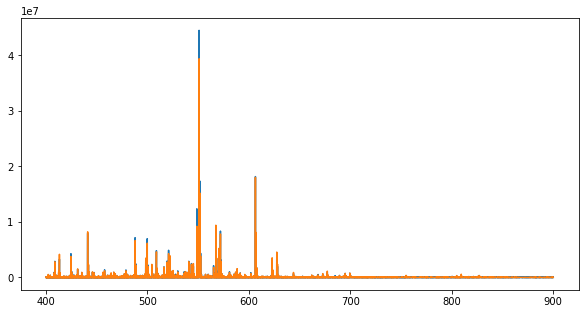

In [56]:
plt.figure(figsize=(10,5))
mz,sp = fid2spec(fid_loaded,m_HR,(400,900))
mz,sp_pred = fid2spec(fid_decoded,m_HR,(400,900))

mz_filter = (mz<1600)&(mz>400)
plt.plot(mz[mz_filter],sp[0][mz_filter])
plt.plot(mz[mz_filter],sp_pred[0][mz_filter])

In [101]:
sp[0,find_peaks(sp[0])[0]]

array([36148.11451611, 36097.22889068, 38707.84421199, ...,
       12403.58650241, 17519.83484547, 19650.19357514])

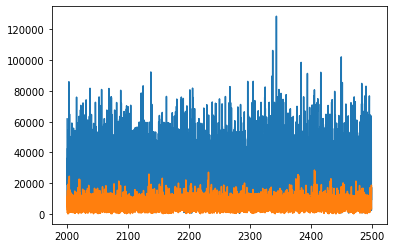

In [64]:
mz_filter = (mz<2500)&(mz>2000)
plt.plot(mz[mz_filter],sp[0][mz_filter])
plt.plot(mz[mz_filter],sp_pred[0][mz_filter])

In [179]:
peak_data_decode = {}
peak_data_orig = {}

for i in tqdm(range(len(cell_ser_file_dir))):
    with h5py.File('E:/20220209_BrainDissociate3D/raw_sc_regional.h5','r') as h5:
        fid_loaded = np.array(h5[cell_ser_file_dir[i]].get('transient'))[:,:65536]
        if fid_loaded.shape[1] != 0:
            signal_encoded = np.array(model_lp(fid_loaded[:,:65536]))
            fid_decoded = decoder(signal_encoded.reshape(1,-1))
            mz,sp = fid2spec(fid_loaded,m_LR,(400,1600))
            mz,sp_pred = fid2spec(fid_decoded,m_HR,(400,1600))
            peak_idx = find_peaks(sp[0],threshold=3*mad(sp[0]))[0]
            peak_idx_decode = find_peaks(sp_pred[0],threshold=3*mad(sp_pred[0]))[0]

            peak_data_orig[cell_ser_file_dir[i]] = {'mz':mz[peak_idx],'intensity':sp[0,peak_idx],'noise':mad(sp[0]),'index':peak_idx}
            peak_data_decode[cell_ser_file_dir[i]] = {'mz':mz[peak_idx_decode],'intensity':sp_pred[0,peak_idx_decode],'noise':mad(sp_pred[0]),'index':peak_idx_decode}

  0%|                                                                                        | 0/13740 [00:00<?, ?it/s]<ipython-input-179-73c063d1634a>:12: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  peak_idx = find_peaks(sp[0],threshold=3*mad(sp[0]))[0]
<ipython-input-179-73c063d1634a>:13: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., sca

KeyError: "Unable to open object (object 'Thalamus\\x_45434y_16067.d' doesn't exist)"

In [196]:
mz[peak_idx_decode]

array([1152.8923486 , 1146.1455486 , 1143.14839575, ...,  400.51464191,
        400.06912453,  400.04080694])

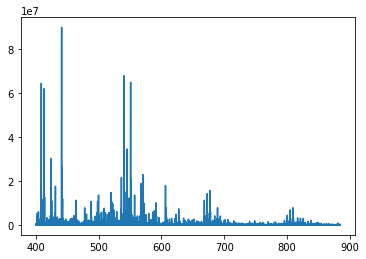

In [192]:
plt.plot(mz[40000:],sp_pred[0][40000:])

In [184]:
peak_data_decode['E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Hip\\x_31195y_11682.d']['mz']

array([1394.05969778, 1148.37457953, 1131.1693517 , ...,  400.06912453,
        400.04889728,  400.04080694])

In [181]:
cell_ser_file_dir

['E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75033y_15293.d',
 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75050y_16593.d',
 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75154y_15888.d',
 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75227y_13834.d',
 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75305y_14826.d',
 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75368y_16543.d',
 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75401y_12938.d',
 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75573y_16682.d',
 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75582y_14117.d',
 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75603y_18813.d',
 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75614y_15238.d',
 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75741y_19

In [124]:
fid_loaded.shape

(1, 65536)

In [19]:
import pickle 
with open('../singlecell_peak_data_decode.pkl', 'rb') as handle:
    peak_data_orig = pickle.load(handle)

In [23]:
del peak_data_orig

In [20]:
peak_data_use = {}
keys = list(peak_data_orig.keys())
for i in tqdm(range(len(keys))):
    peak_data = peak_data_orig[keys[i]]
    snr = peak_data['intensity']/peak_data['noise']
    
    peak_data_use[keys[i]] = {'mz':peak_data['mz'][snr>6],'intensity':peak_data['intensity'][snr>6],'snr':snr[snr>6]}

100%|███████████████████████████████████████████████████████████████████████████| 24083/24083 [01:00<00:00, 398.16it/s]


In [197]:
with open('../peak_data_sc_regional_decode.pkl', 'wb') as handle:
    pickle.dump(peak_data_decode, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [128]:
peak_data_decode.keys()

dict_keys(['E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75033y_15293.d', 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75050y_16593.d', 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75154y_15888.d', 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75227y_13834.d', 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75305y_14826.d', 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75368y_16543.d', 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75401y_12938.d', 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75573y_16682.d', 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75582y_14117.d', 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75603y_18813.d', 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75614y_15238.d', 'E:/20220209_BrainDissociate3D/Slide5_IndividualRegions/Corpus\\x_75741y_194

In [136]:
with open('../peak_data_sc_composite_val_orig.pkl', 'rb') as handle:
    peak_data_orig = pickle.load(handle)
with open('../peak_data_sc_composite_val_decode.pkl', 'rb') as handle:
    peak_data_decode = pickle.load(handle)

In [30]:
import scipy
scipy.io.savemat('../singlecell_peak_data_decode_use.mat',peak_data_decode)

In [171]:
keys = list(peak_data_decode.keys())

with ImzMLWriter('../peak_data_sc_reginoal_orig'+'.imzML') as w:

    for i in tqdm(range(len(keys))):
        # writes data to the .ibd file
        #print(i)
        if peak_data_orig[keys[i]]['mz'].size >0:
            w.addSpectrum(mzs = peak_data_orig[keys[i]]['mz'], intensities = peak_data_orig[keys[i]]['intensity'], coords = tuple([1,i]))

100%|█████████████████████████████████████████████████████████████████████████| 13566/13566 [00:01<00:00, 10685.22it/s]


In [198]:
keys = list(peak_data_decode.keys())

with ImzMLWriter('../peak_data_sc_reginoal_decode'+'.imzML') as w:

    for i in tqdm(range(len(keys))):
        # writes data to the .ibd file
        #print(i)
        if peak_data_decode[keys[i]]['mz'].size >0:
            w.addSpectrum(mzs = peak_data_decode[keys[i]]['mz'], intensities = peak_data_decode[keys[i]]['intensity'], coords = tuple([1,i]))

100%|██████████████████████████████████████████████████████████████████████████| 13566/13566 [00:12<00:00, 1098.64it/s]


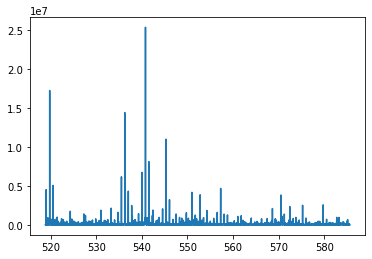

In [135]:
plt.plot(peak_data_decode[keys[11414]]['mz'][25000:30000],peak_data_decode[keys[11414]]['intensity'][25000:30000])
#plt.plot(peak_data_orig[keys[151]]['mz'][25000:30000],peak_data_orig[keys[151]]['intensity'][25000:30000])

In [101]:
len(set(peak_data_decode[keys[151]]['mz'][25000:30000])&set(peak_data_orig[keys[151]]['mz'][25000:30000]))

1383

In [36]:
np.random.seed(199)
names_val = np.random.choice(cell_file_names,1000)

sp_val = []
sp_val_pred = []

for i in tqdm(range(len(names_val))):
    with h5py.File('E:/deepMSI_singlecell/raw_transient_singlecell.h5','r') as h5:
        fid_loaded = np.array(h5[names_val[i]].get('transient'))[:,:fid_length]
        if fid_loaded.shape[1] != 0:
            signal_encoded = np.array(model_lp(fid_loaded[:,:65536]))
            fid_decoded = decoder(signal_encoded.reshape(1,-1))
            mz,sp = fid2spec(fid_loaded,m_HR,(400,1600))
            mz,sp_pred = fid2spec(fid_decoded,m_HR,(400,1600))
            
            sp_val.append(sp)
            sp_val_pred.append(sp_pred)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:00<00:00,  1.19it/s]


In [123]:
peak_val = []
peak_mz = []
peak_val_pred = []

for i in range(len(sp_val)):
    peak_idx = find_peaks(sp_val[i][0])[0]
    peaks = sp_val[i][0][peak_idx]
    noise = mad(sp_val[i][0])
    snr = peaks/noise
    peak_mz.append(mz[peak_idx[snr>6]])
    peak_val.append(sp_val[i][0,peak_idx[snr>6]])
    peak_val_pred.append(sp_val_pred[i][0,peak_idx[snr>6]])

In [126]:
with ImzMLWriter('../singlecell_peak_data_decode_val'+'.imzML') as w:

    for i in tqdm(range(len(peak_val))):
        # writes data to the .ibd file
        #print(i)
        if peak_val_pred[i].size >0:
            w.addSpectrum(mzs = peak_mz[i], intensities = peak_val_pred[i], coords = tuple([1,i]))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.99it/s]


In [140]:
peak_corr = [pearsonr(peak_data_orig[key]['intensity'],peak_data_decode[key]['intensity'])[0] for key in peak_data_orig.keys()]

c:\users\richard\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

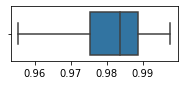

In [142]:
plt.figure(figsize=(3,1))
sns.boxplot(peak_corr,showfliers=False)
#plt.savefig('../figures/singlecell_peakcorr.pdf')

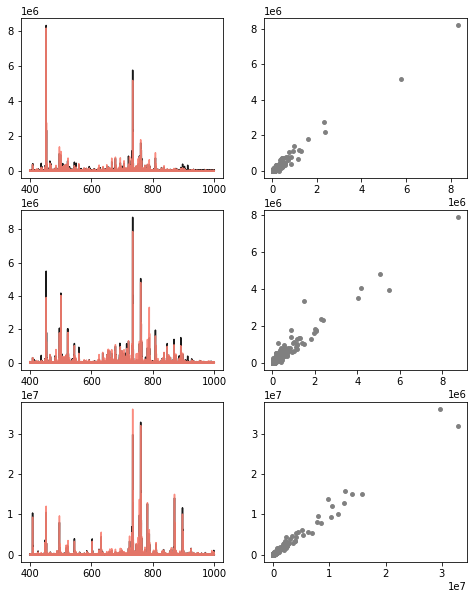

In [148]:
mz_filter = (mz<1000)&(mz>400)
fig,axes = plt.subplots(3,2,figsize=(8,10))
ax = axes.ravel()
idx_show = [922,227,230]
for i,idx in enumerate(idx_show):
    ax[2*i].plot(mz[mz_filter],sp_val[idx][0][mz_filter],'k',alpha=0.9)
    ax[2*i].plot(mz[mz_filter],sp_val_pred[idx][0][mz_filter],'salmon',alpha=0.9)
    ax[2*i+1].scatter(peak_val[idx],peak_val_pred[idx],color='grey',s=15)
fig.savefig('../figures/singlecell_spec_val.pdf')

In [182]:
import h5py

hf = h5py.File('../processed_data/singlecell_peak_data_decode_use_intens.h5', 'w')
keys = list(peak_data_decode.keys())

for key in keys:
    #group = hf.create_group(cell)
    hf.create_dataset(key.split('\\')[1],data=peak_data_decode[key]['intensity'])
    #group.create_dataset('intens',data=peak_data_decode[cell]['intensity'])
hf.close()

In [195]:
import mat73
data_dict = mat73.loadmat('../processed_data/singlecell_peak_data_decode_use_aligned.mat')

In [202]:
data_dict['data']['names']

['x_10001y_12260.d',
 'x_10001y_22958.d',
 'x_10001y_26724.d',
 'x_10001y_32225.d',
 'x_10002y_11750.d',
 'x_10002y_13939.d',
 'x_10005y_18625.d',
 'x_10006y_7099.d',
 'x_10007y_20993.d',
 'x_10009y_21962.d',
 'x_10009y_32071.d',
 'x_10010y_16628.d',
 'x_10010y_17483.d',
 'x_10010y_20052.d',
 'x_10010y_34646.d',
 'x_10011y_22909.d',
 'x_10011y_35301.d',
 'x_10012y_14168.d',
 'x_10012y_17838.d',
 'x_10015y_15607.d',
 'x_10015y_26892.d',
 'x_10016y_24304.d',
 'x_10016y_5982.d',
 'x_10017y_7497.d',
 'x_10018y_15019.d',
 'x_10018y_32859.d',
 'x_10019y_5640.d',
 'x_10021y_29172.d',
 'x_10021y_31310.d',
 'x_10021y_6267.d',
 'x_10021y_763.d',
 'x_10022y_2542.d',
 'x_10023y_19245.d',
 'x_10023y_20065.d',
 'x_10023y_4431.d',
 'x_10024y_15284.d',
 'x_10024y_24625.d',
 'x_10024y_5356.d',
 'x_10026y_22850.d',
 'x_10026y_32852.d',
 'x_10026y_8764.d',
 'x_10027y_12551.d',
 'x_10027y_16560.d',
 'x_10027y_19642.d',
 'x_10027y_24840.d',
 'x_10027y_29982.d',
 'x_10028y_15160.d',
 'x_10028y_22837.d',
 'x

In [209]:
sc_data = pd.DataFrame(data_dict['data']['intens'].T,columns=data_dict['data']['mzs'],index=data_dict['data']['names'])

In [210]:
sc_data

,400.021222,400.031222,400.035222,400.037444,400.039444,400.047444,400.061667,400.065667,400.067667,400.071667,...,1599.183333,1599.310000,1599.410000,1599.536667,1599.603333,1599.663333,1599.763333,1599.830000,1599.890000,1599.956667
x_10001y_12260.d,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,32360.776142,0.0,88886.367108,0.000000,0.000000,0.000000,13264.027001,0.0,0.0,0.0
x_10001y_22958.d,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,3547.701407,0.000000,0.0,0.0,0.0
x_10001y_26724.d,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,18124.207614,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
x_10001y_32225.d,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,13974.740848,...,0.000000,0.0,20708.255340,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
x_10002y_11750.d,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,6234.238502,7263.719717,...,0.000000,0.0,36194.562736,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x_9997y_13470.d,0.0,0.0,0.0,0.0,0.0,0.0,12189.573986,0.0,9131.297601,12893.147513,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
x_9997y_15638.d,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,8324.260723,...,0.000000,0.0,8949.593182,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
x_9998y_15774.d,0.0,0.0,0.0,0.0,0.0,0.0,5067.920716,0.0,5446.013245,8697.000952,...,0.000000,0.0,0.000000,6233.056646,0.000000,0.000000,7358.097953,0.0,0.0,0.0
x_9998y_33525.d,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,4859.285391,0.0,30577.889331,0.000000,5902.687838,0.000000,0.000000,0.0,0.0,0.0


In [215]:
sc_data = sc_data.iloc[:,sc_data.astype(bool).sum(axis=0).values>0.15*sc_data.shape[0]]

In [219]:
adducts = ['M+H','M+Na','M+K']
site_url = 'https://www.lipidmaps.org/rest/moverz/LIPIDS'

annot_df, matched, unmatched = LipidMaps_annotate(sc_data.columns, adducts, 2, site_url)

annot_df['ppm'] = annot_df['Delta']/annot_df['Input m/z']*1e6

  0%|                                                                                         | 0/9438 [00:00<?, ?it/s]<ipython-input-219-e30a3d941871>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  annot_df, matched, unmatched = LipidMaps_annotate(sc_data.columns, adducts, 2, site_url)
100%|████████████████████████████████████████████████████████████████████████████| 9438/9438 [4:59:19<00:00,  1.90s/it]


In [222]:
annot_df.to_pickle('../singlecell_decode_annot.pkl')

In [223]:
annot_df = pd.read_pickle('../singlecell_decode_annot.pkl')

In [226]:
sc_data[annot_df['Input m/z'].unique()].to_pickle('../matched_data_singlecell_aligned.pkl')